In [3]:
from tree_sitter import Language, Parser
import networkx as nx
import matplotlib.pyplot as plt
from regraph import NXGraph, Rule
from regraph import plot_graph, plot_instance, plot_rule

In [4]:
code_1 = """
import numpy as np

def perform_bernoulli_trials(n, p):

    # Initialize number of successes: n_success
    n_success = 0

    # Perform trials
    for i in range(n):
        # Choose random number between zero and one: random_number
        random_number = np.random.random()

        # If less than p, it's a success so add one to n_success
        if random_number < p:
            n_success += 1

    return n_success
"""

code_2 = """
import numpy as np

def perform_bernoulli_trials(n, p):

    # Initialize number of successes: n_success
    n_success = 0

    return n_success
"""

code_3 = """
import numpy as np
import libs as l

def perform_bernoulli_trials(n, p):

    # Initialize number of successes: n_success
    n_success = 0
    return n_success
    
print("Python is great!")

np.ndarray(size=(5,5))

x = 5 * 3
"""

In [11]:
def py_init():
    Language.build_library(
        # Store the library in the `build` directory
        'build/my-languages.so',

        # Include one or more languages
        [
            'tree-sitter-python'
        ]
    )


def r_init():
    Language.build_library(
        # Store the library in the `build` directory
        'build/my-languages.so',

        # Include one or more languages
        [
            'tree-sitter-r'
        ]
    )

In [12]:
py_init()

In [13]:
PY_LANGUAGE = Language('build/my-languages.so', 'python')
python_parser = Parser()
python_parser.set_language(PY_LANGUAGE)

In [6]:
def parse_py(code):
    
    # get a tree
    tree = python_parser.parse(bytes(code, "utf8"))

    # traverse tree to get nodes & edges
    G = NXGraph()
    
    G = bfs_tree_traverser(tree.root_node, G)
    return G

In [7]:
def bfs_tree_traverser(root_node, G):
    # node_id = id of current node being traversed
    # parent_id = id of the parent of the current node
    node_id, parent_id = 0, 0
    # lists to queue the nodes in order and identify already visited nodes
    visited, queue = [], []

    visited.append(root_node)
    queue.append(root_node)

    # add root_node to the graph
    G.add_node(0, attrs={"type": root_node.type, "text": root_node.text})

    # loop to visit each node
    while queue:
        node = queue.pop(0)

        for child_node in node.children:
            if child_node not in visited:
                node_id += 1
                # add child node to graph
                G.add_node(node_id, attrs={"type": child_node.type, "text": child_node.text, "parent_id":parent_id})
                # add edge between parent_node and child_node
                G.add_edge(parent_id, node_id)

                visited.append(child_node)
                queue.append(child_node)

        # set parent_id to the id of the next node in queue
        parent_id = parent_id + 1

    return G

In [8]:
G = parse_py(code_3)
type(G)

NameError: name 'python_parser' is not defined

In [9]:
pattern_from_graph = G
rule3 = Rule.from_transform(pattern_from_graph)
plot_rule(rule3)

NameError: name 'G' is not defined

--------------------------------------

<h2>Graph Simplification by Node Generalization</h2>

In [11]:
parsed_json = G.to_json()

# print clear view of all nodes and their edges
print("List of nodes: ")
for n, attrs in G.nodes(data=True):
    print("\t", n, attrs)
print("List of edges: ")
for s, t, attrs in G.edges(data=True):
    print("\t{}->{}".format(s, t), attrs)

List of nodes: 
	 0 {'type': {'module'}, 'text': {b'import numpy as np\nimport libs as l\n\ndef perform_bernoulli_trials(n, p):\n\n    # Initialize number of successes: n_success\n    n_success = 0\n    return n_success\n    \nprint("Python is great!")\n\nnp.ndarray(size=(5,5))\n\nx = 5 * 3\n'}}
	 1 {'type': {'import_statement'}, 'text': {b'import numpy as np'}, 'parent_id': {0}}
	 2 {'type': {'import_statement'}, 'text': {b'import libs as l'}, 'parent_id': {0}}
	 3 {'type': {'function_definition'}, 'text': {b'def perform_bernoulli_trials(n, p):\n\n    # Initialize number of successes: n_success\n    n_success = 0\n    return n_success'}, 'parent_id': {0}}
	 4 {'type': {'expression_statement'}, 'text': {b'print("Python is great!")'}, 'parent_id': {0}}
	 5 {'type': {'expression_statement'}, 'text': {b'np.ndarray(size=(5,5))'}, 'parent_id': {0}}
	 6 {'type': {'expression_statement'}, 'text': {b'x = 5 * 3'}, 'parent_id': {0}}
	 7 {'type': {'import'}, 'text': {b'import'}, 'parent_id': {1}}

In [12]:
def remove_descendants(node_type, instances, rule):
    print(node_type)
    for ins in instances:
        node_id = ins[node_type]
        print(str(node_id) + ":")
        desc = G.descendants(node_id)
        print(desc)
        for id in list(desc):
            rule.inject_remove_node(id)
    return rule


# removes all the nodes and edges of all nodes in rule whose ids are not in the list
def remove_everything_else(ids, rule, num_nodes):
    for i in range(num_nodes):
        if i not in ids:
            rule.inject_remove_node(i)
    return rule


# gets the ids of all of the nodes of a certain "type" in an instance of a graph
def get_ids(node_type, instances):
    ids = []
    for ins in instances:
        node_id = ins[node_type]
        ids.append(node_id)
    return ids

# creates a pattern to filter a graph based on "node type"
# attr_name -> name given to the variable used to identify this node type
# node_type -> the type of node that wants to be filtered
def create_simple_pattern(attr_name, node_type):
    pattern = NXGraph()
    pattern.add_node(attr_name)
    pattern.add_node_attrs(attr_name, {"type" : node_type})
    return pattern

# creates a subgraph of the nodes given in ids, searches for their descendants that match the different given patterns
# and adds the text attribute of nodes that match those patterns as an attribute to the ascendant node
def add_attrs_from_patterns(ids, patterns, is_import):

    for id in ids:
        subg_nodes = list(G.descendants(id)) if is_import else list(G.successors(id))
        subg_nodes.append(id)
        subgraph = G.generate_subgraph(G, subg_nodes)
        
        for patt in patterns:
            
            instances = subgraph.find_matching(patt[1])
            sub_id = get_ids(patt[0], instances)
            
            G.add_node_attrs(id, attrs={patt[0] : subgraph.get_node(sub_id[0])["text"]})
            

# adds an edge between the parent of a node and all the children of that same node (grandparent - grandchildren connection)
# this is necessary in order to later be able to remove those nodes that only serve as connectors
def connect_parent_and_children(ids, rule):
    for id in ids:
        parent_id = list(G.predecessors(id))[0]
        for child_id in list(G.successors(id)):
            rule.inject_add_edge(parent_id, child_id)
    return rule

----------

<h3>Approach: Specify "relevant" nodes and delete the rest</h3>

<b>Create patterns to select the "relevant" nodes:</b>

In [28]:
pattern1 = create_simple_pattern("import", "import_statement")
pattern2 = create_simple_pattern("function_def", "function_definition")
pattern3 = create_simple_pattern("function_call", "call")
pattern4 = create_simple_pattern("var_assignment", "assignment")
pattern5 = create_simple_pattern("first_node", "module")
pattern6 = create_simple_pattern("code_block", "block")
pattern7 = create_simple_pattern("if", "if_statement")
pattern8 = create_simple_pattern("for", "for_statement")
pattern9 = create_simple_pattern("expr_statement", "expression_statement")

In [40]:
G = parse_py(code_3)
rule = Rule.from_transform(G)
all_ids = []

<b>Import statements:</b><br>

In [41]:
# pattern matching of import_statements
instances = G.find_matching(pattern1)
this_ids = get_ids("import", instances)
all_ids += this_ids

patterns = []

# pattern to get the library name
patt = create_simple_pattern("library", "dotted_name")
patterns.append(("library", patt))

# pattern to get the alias
patt = create_simple_pattern("alias", "identifier")
patterns.append(("alias", patt))

add_attrs_from_patterns(this_ids, patterns, True)

<p style="color:red;"><b>Missing cases when import statements are called using "from lib import x".</b></p>

<b>Functions definitions:</b>

In [42]:
# pattern matching of function_definition
instances = G.find_matching(pattern2)
this_ids = get_ids("function_def", instances)
all_ids += this_ids

patterns = []

# pattern to get the function name
patt = create_simple_pattern("function", "identifier")
patterns.append(("function", patt))

# pattern to get the parameters
patt = create_simple_pattern("parameters", "parameters")
patterns.append(("parameters", patt))

add_attrs_from_patterns(this_ids, patterns, False)

<p style="color:red;"><b>Add return statements?</b></p>

<b>Functions calls:</b>

In [43]:
# pattern matching of function call
instances = G.find_matching(pattern3)
this_ids = get_ids("function_call", instances)
all_ids += this_ids

patterns = []

# pattern to get the function arguments
patt = create_simple_pattern("arguments", "argument_list")
patterns.append(("arguments", patt))

add_attrs_from_patterns(this_ids, patterns, False)

<b>Code blocks (connector node):</b>

In [44]:
instances = G.find_matching(pattern6)
this_ids = get_ids("code_block", instances)
#all_ids += this_ids

rule = connect_parent_and_children(this_ids, rule)

# for id in this_ids:
#     print(id)
#     rule.inject_remove_node(id)

<b>Expression statements (connector node):</b>

In [45]:
instances = G.find_matching(pattern9)
this_ids = get_ids("expr_statement", instances)
#all_ids += this_ids

rule = connect_parent_and_children(this_ids, rule)

# for id in this_ids:
#     print(id)
#     rule.inject_remove_node(id)

<p style="color:red;"><b>Solve issue where expression statements end up being disconnected from the rest of the graph if their parent is an already removed "block" node</b></p>

<b>To do:</b>
<ul>
    <li>for loops</li>
    <li>while loops</li>
    <li>variable assignments</li>
    <li>if statements</li>
    <li>else if and else statements</li>
</ul>

In [46]:
instances = G.find_matching(pattern4)
this_ids = get_ids("var_assignment", instances)
all_ids += this_ids

instances = G.find_matching(pattern5)
this_ids = get_ids("first_node", instances)
all_ids += this_ids

instances = G.find_matching(pattern7)
this_ids = get_ids("if", instances)
all_ids += this_ids

instances = G.find_matching(pattern8)
this_ids = get_ids("for", instances)
all_ids += this_ids


<p style="color:red;"><b>We need to find more types of nodes and create patterns for each of them.</b></p>

<p style="color:red;"><b>We need to test if what we have also works with R.</b></p>

<b>Delete all nodes that are not "relevant":</b>

In [47]:
rule = remove_everything_else(all_ids, rule, len(parsed_json["nodes"]))

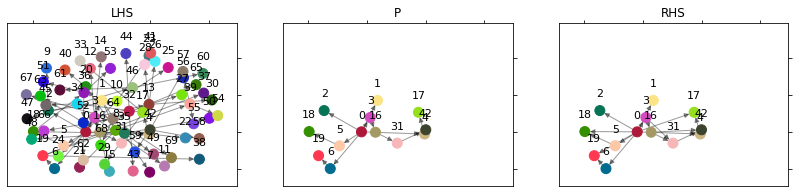

In [48]:
plot_rule(rule)

--------

<h3>Approach: Specify "relevant" nodes and remove all their descendants</h3>

In [124]:
rule = Rule.from_transform(G)

instances1 = G.find_matching(pattern1)
rule = remove_descendants("import", instances1, rule)

instances2 = G.find_matching(pattern2)
rule = remove_descendants("function", instances2, rule)

instances3 = G.find_matching(pattern3)
rule = remove_descendants("expression", instances3, rule)

plot_rule(rule)

import
1:
{3, 4, 11, 12, 13, 21}
function
2:
{5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27}
expression
19:
{25, 26, 27, 22}


RuleError: Node '25' does not exist in the preserved part

<b>Won't work since we won't be able to analyze the content of a function for example, since everything inside would be deleted. Nested functions wouldn't be possible.</b>

----------------------------------

<h2>Playground</h2>

In [14]:
# Create an empty graph object
graph = NXGraph()

# Add a list of nodes, optionally with attributes
graph.add_nodes_from(
    [
        'Alice',
        ('Bob', {'age': 15, 'gender': 'male'}),
        ('Jane', {'age': 40, 'gender': 'female'}),
        ('Eric', {'age': 55, 'gender': 'male'})
])

# Add a list of edges, optionally with attributes
graph.add_edges_from([
    ("Alice", "Bob"),
    ("Jane", "Bob", {"type": "parent", "since": 1993}),
    ("Eric", "Jane", {"type": "friend", "since": 1985}),
    ("Eric", "Alice", {"type": "parent", "since": 1992}),
])

graph_json = graph.to_json()

In [15]:
print("List of nodes: ")
for n, attrs in graph.nodes(data=True):
    print("\t", n, attrs)
print("List of edges: ")
for s, t, attrs in graph.edges(data=True):
    print("\t{}->{}".format(s, t), attrs)

List of nodes: 
	 Alice {}
	 Bob {'age': {15}, 'gender': {'male'}}
	 Jane {'age': {40}, 'gender': {'female'}}
	 Eric {'age': {55}, 'gender': {'male'}}
List of edges: 
	Alice->Bob {}
	Jane->Bob {'type': {'parent'}, 'since': {1993}}
	Eric->Jane {'type': {'friend'}, 'since': {1985}}
	Eric->Alice {'type': {'parent'}, 'since': {1992}}


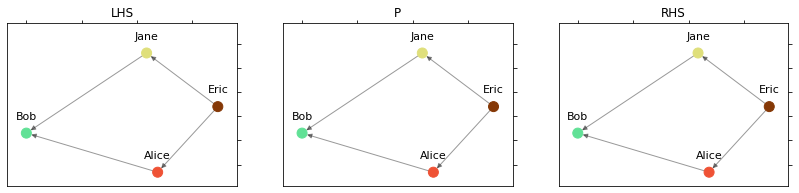

In [21]:
rule = Rule.from_transform(graph)
plot_rule(rule)

In [22]:
pattern = NXGraph()
pattern.add_nodes_from(["x"])
pattern.add_node_attrs("x", {"age" : 15})

In [23]:
instances = graph.find_matching(pattern)
instances

[{'x': 'Bob'}]

In [24]:
print("List of nodes: ")
for n, attrs in graph.nodes(data=True):
    print("\t", n, attrs)
print("List of edges: ")
for s, t, attrs in graph.edges(data=True):
    print("\t{}->{}".format(s, t), attrs)

List of nodes: 
	 Alice {}
	 Bob {'age': {15}, 'gender': {'male'}}
	 Jane {'age': {40}, 'gender': {'female'}}
	 Eric {'age': {55}, 'gender': {'male'}}
List of edges: 
	Alice->Bob {}
	Jane->Bob {'type': {'parent'}, 'since': {1993}}
	Eric->Jane {'type': {'friend'}, 'since': {1985}}
	Eric->Alice {'type': {'parent'}, 'since': {1992}}
